[![deep-learning-notes](https://github.com/semilleroCV/deep-learning-notes/raw/main/assets/banner-notebook.png)](https://github.com/semilleroCV/deep-learning-notes)

# ViT in Pytorch from scract!

In [ ]:
#@title **Install required packages**

!pip install torchinfo

In [6]:
#@title **Import required libraries**.

# Pytorch essentials
import torch #  2.0.0
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms #  0.15.1
from einops import rearrange, repeat #  0.7.0
from torchinfo import summary # 1.8.0
import math


Vision Transformers (ViT) have revolutionized computer vision by adapting the self-attention mechanism from NLP to image processing. Unlike CNNs, which struggle with long-range dependencies due to their inherent inductive bias, ViTs treat images as sequences of fixed-size patches, enabling global context modeling. This approach has yielded state-of-the-art performance on benchmarks like ImageNet, outperforming CNNs with significantly fewer parameters and FLOPs. ViT's key innovations include:

1. Patch embedding: Flattening and projecting image patches to a lower-dimensional space.
2. Learnable position embeddings: Capturing spatial information without explicit convolutions.
3. Multi-head self-attention: Allowing the model to attend to different representation subspaces concurrently.
4. MLP blocks with GELU activations: Introducing non-linearity and increasing model capacity.

ViTs excel in transfer learning scenarios, demonstrating exceptional scalability when pre-trained on large datasets Their architecture also lends itself well to self-supervised learning techniques like masked autoencoders.

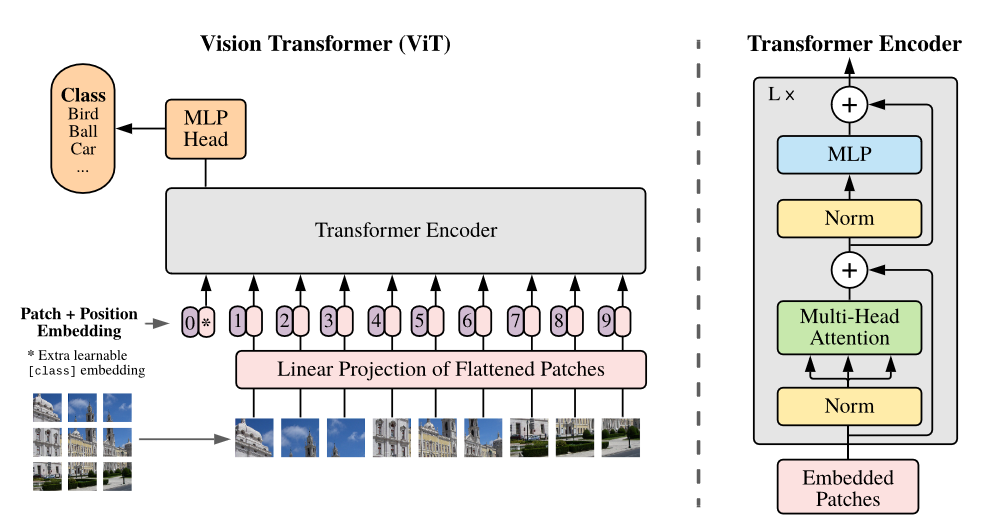

 In this notebook, i will implement a ViT from the ground up in PyTorch, dissecting each component to understand its role in the model's remarkable performance across various vision tasks.

 The code has comments to help you understand the dimensions of the tensors at each step.

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=8, in_chans=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # b, embedding, n_patches_h, n_patches_w

    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b e n1 n2 -> b (n1 n2) e') # b, long, embedding
        return x


class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()

        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd * n_heads)
        self.query = nn.Linear(n_embd, n_embd * n_heads)
        self.value = nn.Linear(n_embd, n_embd * n_heads)
        self.n_heads = n_heads

        # output projection
        self.proj = nn.Linear(n_embd * n_heads, n_embd)


    def forward(self, x):
        # B, L, F = x.size() # batch, length, features

        k = rearrange(self.key(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)
        q = rearrange(self.query(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)
        v = rearrange(self.value(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)

        scores = q @ k.transpose(-2,-1) / math.sqrt(k.size(-1)) # B, H, L, L
        att = F.softmax(scores, dim=-1)

        y = att @ v # B, H, L, F/H

        y = rearrange(y, 'b h l f -> b l (h f)')


        y = self.proj(y) # batch, length, feature

        return y


class MultiLayerPerceptron(nn.Module):
    def __init__(self, n_embd, mlp_ratio):
        super().__init__()

        hidden_dim = int(n_embd * mlp_ratio)
        self.MLP = nn.Sequential(
            nn.Linear(n_embd, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd)
        )

    def forward(self,x):
        x = self.MLP(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, n_embd, n_heads, mlp_ratio):
        super().__init__()

        self.att = MultiHeadAttention(n_embd, n_heads)
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.mlp = MultiLayerPerceptron(n_embd, mlp_ratio)

    def forward(self, x):

        x1 = self.ln1(x) #layer normalization
        x1 = self.att(x1) # multihead attention

        x = x + x1 # residual connection

        x2 = self.ln2(x) #layer normalization
        x2 = self.mlp(x2) # multilayer perceptron

        y = x + x2 # residual connection

        return y


class ViT(nn.Module):

    def __init__(self,img_dim= 224 , patch_dim=7, embed_dim=100, num_classes=10, n_heads=8, depth=2, mlp_ratio=.4):
        super().__init__()


        self.patch_embed = PatchEmbedding(patch_dim, 3, embed_dim)
        self.cls_token = nn.Parameter( torch.randn(1, 1, embed_dim))

        n_patches = (img_dim // patch_dim) ** 2
        self.pos_embedding = nn.Parameter( torch.randn(1, n_patches+1, embed_dim))

        self.transformer = nn.Sequential(*[TransformerEncoder(embed_dim, n_heads, mlp_ratio) for _ in range(depth)])
        self.MLP_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        e = self.patch_embed(x) # (B, L, F) 

        #cls token addition
        cls = repeat(self.cls_token, '1 1 f -> b 1 f', b=e.shape[0])

        e = torch.cat([cls, e], dim=1) + self.pos_embedding # (B, L+1, F)

        e += self.pos_embedding

        z = self.transformer(e) # (B, L+1, F)

        cls_token = z[:, 0, :]  # (B, F)

        y = self.MLP_head(cls_token) # (B, num_classes)

        return y

here is the example of the Vit-Base model, for more large versions check the paper https://arxiv.org/pdf/2010.11929 , t oget the other version just modify the parameters of the constructor of the model.

In [19]:
model = ViT(img_dim= 224 ,
            patch_dim=7, 
            embed_dim=100,
            num_classes=10,
            n_heads=8, 
            depth=2, 
            mlp_ratio=.4)


In [20]:
# input size for this config: 224x224x3
random_input = torch.randn(1, 3, 224, 224)  # B,C,H,W
output = model(random_input)
# output size for this config: 10 probs
print(output.shape)

torch.Size([1, 1, 100])
torch.Size([1, 10])


In [33]:
summary(model, random_input.size(), col_names=["input_size", "output_size", "num_params"], depth=10)

torch.Size([1, 1, 100])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
ViT                                           [1, 3, 224, 224]          [1, 10]                   102,600
├─PatchEmbedding: 1-1                         [1, 3, 224, 224]          [1, 1024, 100]            --
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 100, 32, 32]          14,800
├─Sequential: 1-2                             [1, 1025, 100]            [1, 1025, 100]            --
│    └─TransformerEncoder: 2-2                [1, 1025, 100]            [1, 1025, 100]            --
│    │    └─LayerNorm: 3-1                    [1, 1025, 100]            [1, 1025, 100]            200
│    │    └─MultiHeadAttention: 3-2           [1, 1025, 100]            [1, 1025, 100]            --
│    │    │    └─Linear: 4-1                  [1, 1025, 100]            [1, 1025, 800]            80,800
│    │    │    └─Linear: 4-2                  [1, 1025, 100]            

please feel free to improve this version of ViT 